In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
dataset = pd.read_csv("dataset.csv")

In [3]:
dataset.head()

,Volume,20_sma,upper_bb,lower_bb,rsi,macd,signal,hist,Close,targetNextClose,target
0,82337700,275.665997,283.763488,267.568507,60.507731,0.805713,-0.356278,1.161991,279.679993,280.200012,0.520019
1,47047600,275.938998,284.269837,267.608160,61.865842,0.919324,-0.101158,1.020482,280.200012,281.609985,1.409973
2,68026900,276.469498,284.827304,268.111691,65.345664,1.110335,0.141141,0.969194,281.609985,284.010010,2.400025
3,78882900,277.089998,285.762378,268.417617,70.311778,1.438789,0.400670,1.038119,284.010010,283.339996,-0.670014
4,57919500,277.789497,286.081756,269.497238,67.407615,1.626280,0.645792,0.980488,283.339996,281.420013,-1.919983


In [4]:
dataset = dataset.filter(['Volume','20_sma', 'upper_bb','lower_bb', 'rsi','macd', 'signal', 'hist','Close', 'target'])

In [5]:
dataset.head()

,Volume,20_sma,upper_bb,lower_bb,rsi,macd,signal,hist,Close,target
0,82337700,275.665997,283.763488,267.568507,60.507731,0.805713,-0.356278,1.161991,279.679993,0.520019
1,47047600,275.938998,284.269837,267.608160,61.865842,0.919324,-0.101158,1.020482,280.200012,1.409973
2,68026900,276.469498,284.827304,268.111691,65.345664,1.110335,0.141141,0.969194,281.609985,2.400025
3,78882900,277.089998,285.762378,268.417617,70.311778,1.438789,0.400670,1.038119,284.010010,-0.670014
4,57919500,277.789497,286.081756,269.497238,67.407615,1.626280,0.645792,0.980488,283.339996,-1.919983


In [6]:
n = len(dataset)
train_df = dataset[0:int(n*0.7)]
val_df = dataset[int(n*0.7):int(n*0.9)]
test_df = dataset[int(n*0.9):]

In [7]:
scaler = MinMaxScaler()
scaler.fit(train_df)

MinMaxScaler()

In [8]:
train = scaler.transform(train_df)
val = scaler.transform(val_df)
test = scaler.transform(test_df)

In [9]:
X_train = train[:,:-2]
y_train = train[:,[8,9]]

X_val = val[:,:-2]
y_val = val[:,[8,9]]

X_test = test[:,:-2]
y_test = test[:,[8,9]]

In [10]:
window_length = 4
batch_size = 32
num_features = 9
train_generator = TimeseriesGenerator(X_train, y_train, length=window_length, sampling_rate=1, batch_size=batch_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=window_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=window_length, sampling_rate=1, batch_size=batch_size)

In [11]:
model = Sequential()

model.add(LSTM(units=1000, return_sequences=True, input_shape=(window_length,num_features)))
model.add(LSTM(units=1000,return_sequences=True))
model.add(LSTM(units=100,return_sequences=False))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=2, activation='linear'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 1000)           4040000   
                                                                 
 lstm_1 (LSTM)               (None, 4, 1000)           8004000   
                                                                 
 lstm_2 (LSTM)               (None, 100)               440400    
                                                                 
 dense (Dense)               (None, 64)                6464      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0

In [13]:
model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])

In [15]:
history = model.fit(train_generator, epochs=50, validation_data=val_generator, shuffle=False)

Epoch 1/50
27/27 [==============================] - 11s 235ms/step - loss: 0.0635 - mean_absolute_error: 0.2028 - val_loss: 0.0302 - val_mean_absolute_error: 0.1414
Epoch 2/50
27/27 [==============================] - 5s 201ms/step - loss: 0.0668 - mean_absolute_error: 0.2097 - val_loss: 0.0325 - val_mean_absolute_error: 0.1513
Epoch 3/50
27/27 [==============================] - 5s 200ms/step - loss: 0.0703 - mean_absolute_error: 0.2099 - val_loss: 0.0212 - val_mean_absolute_error: 0.1221
Epoch 4/50
27/27 [==============================] - 5s 200ms/step - loss: 0.0694 - mean_absolute_error: 0.2147 - val_loss: 0.0384 - val_mean_absolute_error: 0.1614
Epoch 5/50
27/27 [==============================] - 5s 204ms/step - loss: 0.0481 - mean_absolute_error: 0.1767 - val_loss: 0.0354 - val_mean_absolute_error: 0.1541
Epoch 6/50
27/27 [==============================] - 5s 200ms/step - loss: 0.0548 - mean_absolute_error: 0.1862 - val_loss: 0.0410 - val_mean_absolute_error: 0.1683
Epoch 7/50
27/2

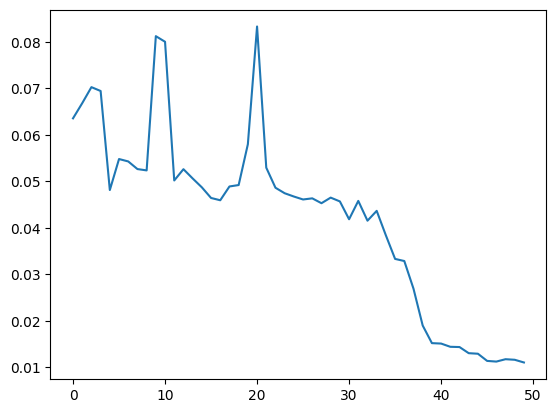

In [16]:
plt.plot(history.history['loss'])
plt.show()

In [17]:
model.evaluate(test_generator, verbose=1)

4/4 [==============================] - 0s 73ms/step - loss: 0.0324 - mean_absolute_error: 0.1491


[0.03240577504038811, 0.14905105531215668]

In [19]:
predictions = model.predict(test_generator)

4/4 [==============================] - 0s 68ms/step


In [22]:
inv_transform = pd.DataFrame(data=X_test, columns=['Volume','20_sma', 'upper_bb','lower_bb', 'rsi','macd', 'signal', 'hist'])
predicted_stock_price = pd.DataFrame(data=predictions, columns=['predictedClose', 'predictedTarget'])

In [23]:
inv_transform = inv_transform.join(predicted_stock_price)

In [24]:
inv_transform = scaler.inverse_transform(inv_transform)

In [25]:
predictions = pd.DataFrame(data=inv_transform, columns=['Volume','20_sma', 'upper_bb','lower_bb', 'rsi','macd', 'signal', 'hist', 'predictedClose', 'predictedTarget'])

In [26]:
target = pd.DataFrame(data=X_test, columns=['Volume','20_sma', 'upper_bb','lower_bb', 'rsi','macd', 'signal', 'hist'])
y_test = pd.DataFrame(data=y_test, columns=['Close', 'target'])

In [27]:
target = target.join(y_test)

In [28]:
target = scaler.inverse_transform(target)

In [29]:
target = pd.DataFrame(data=target, columns=['Volume','20_sma', 'upper_bb','lower_bb', 'rsi','macd', 'signal', 'hist', 'Close', 'target'])

In [30]:
predictions = predictions.join(target['Close'])
predictions = predictions.join(target['target'])

In [31]:
predictions.head()

,Volume,20_sma,upper_bb,lower_bb,rsi,macd,signal,hist,predictedClose,predictedTarget,Close,target
0,77289800.0,396.027501,413.482422,378.572580,55.317127,6.042807,5.844170,0.198636,337.753225,-0.861253,399.589996,-5.760009
1,77972200.0,396.721500,412.508993,380.934006,50.202746,5.107641,5.696864,-0.589224,338.964038,-0.875982,393.829987,-0.669983
2,65927900.0,397.279500,411.596570,382.962429,49.627988,4.263308,5.410153,-1.146845,341.818261,-0.914527,393.160004,3.079986
3,60737900.0,398.384999,407.725199,389.044800,52.329914,3.798906,5.087904,-1.288998,342.692021,-0.926145,396.239990,-2.959991
4,81447700.0,398.314499,407.792400,388.836598,49.577612,3.155641,4.701451,-1.545810,340.002196,-0.888343,393.279999,5.670013


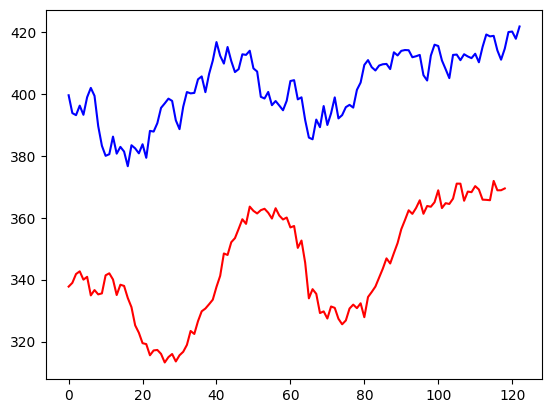

In [32]:
plt.plot(predictions['predictedClose'], color='red')
plt.plot(predictions['Close'], color='blue')

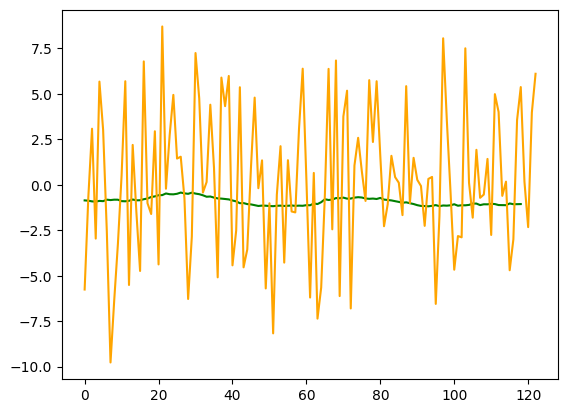

In [33]:
plt.plot(predictions['predictedTarget'], color='green')
plt.plot(predictions['target'], color='orange')

In [43]:
plot_all = scaler.transform(dataset)

In [44]:
plot_all_X = plot_all[:,:-2]
plot_all_Y = plot_all[:,[8,9]]

In [45]:
plot_all_gen = TimeseriesGenerator(plot_all_X, plot_all_Y, length=window_length, sampling_rate=1, batch_size=batch_size)

In [46]:
all_predict = model.predict(plot_all_gen)

39/39 [==============================] - 3s 66ms/step


In [47]:
line_predict = pd.DataFrame(plot_all_X, columns=['Volume','20_sma', 'upper_bb','lower_bb', 'rsi','macd', 'signal', 'hist'])
predicted__lvls = pd.DataFrame(data=all_predict, columns=['predictedClose', 'predictedTarget'])

In [49]:
line_predict = line_predict.join(predicted__lvls)

In [50]:
line_predict = scaler.inverse_transform(line_predict)

In [51]:
predictions2 = pd.DataFrame(data=line_predict, columns=['Volume','20_sma', 'upper_bb','lower_bb', 'rsi','macd', 'signal', 'hist', 'predictedClose', 'predictedTarget'])

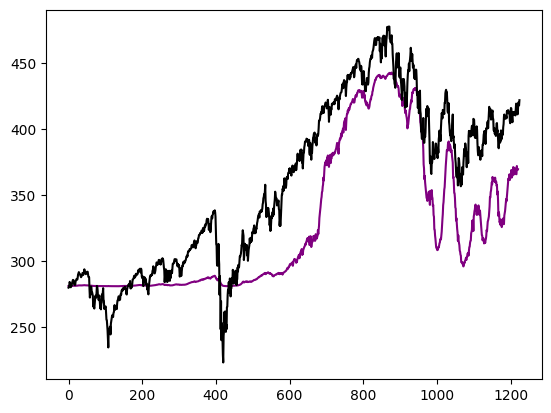

In [54]:
plt.plot(predictions2['predictedClose'], color='purple')
plt.plot(dataset['Close'], color='black')

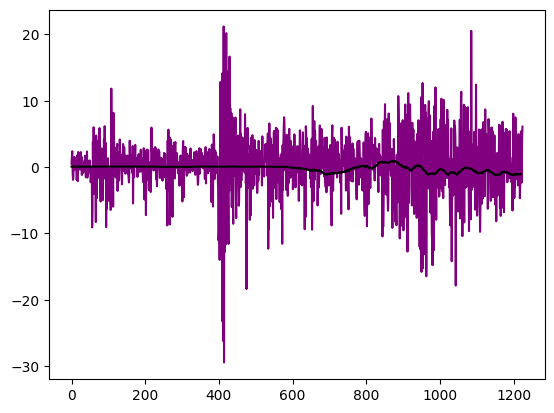

In [57]:
plt.plot(dataset['target'], color='purple')
plt.plot(predictions2['predictedTarget'], color='black')

In [100]:
realTime = pd.read_csv("real_dataset.csv")

In [101]:
realTime = realTime.filter(['Volume','20_sma', 'upper_bb','lower_bb', 'rsi','macd', 'signal', 'hist','Close', 'target'])

In [102]:
realTime = realTime.iloc[22:,:]

In [103]:
real_time = scaler.transform(realTime)

In [104]:
real_time_X = real_time[:,:-2]
real_time_y = real_time[:,[8,9]]

In [105]:
generator = TimeseriesGenerator(real_time_X, real_time_y, length=window_length, sampling_rate=1, batch_size=1)

In [106]:
real_predict = model.predict(generator)

1/1 [==============================] - 0s 40ms/step


In [107]:
real_predict

array([[0.59236866, 0.5606046 ]], dtype=float32)

In [111]:
real_time_X = real_time_X[4:]

In [112]:
predict_real = pd.DataFrame(real_time_X, columns=['Volume','20_sma', 'upper_bb','lower_bb', 'rsi','macd', 'signal', 'hist'])
predicted_Rlvls = pd.DataFrame(data=real_predict, columns=['predictedClose', 'predictedTarget'])
predict_real = predict_real.join(predicted_Rlvls)
predict_real = scaler.inverse_transform(predict_real)
predict_real = pd.DataFrame(data=predict_real, columns=['Volume','20_sma', 'upper_bb','lower_bb', 'rsi','macd', 'signal', 'hist', 'predictedClose', 'predictedTarget'])

In [115]:
predict_real[['predictedClose', 'predictedTarget']]

,predictedClose,predictedTarget
0,369.733024,-1.058557
